In [18]:
from datetime import datetime, timedelta

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
from metpy.interpolate import interpolate_to_grid
from metpy.io import add_station_lat_lon
from metpy.plots import StationPlot
from metpy.units import units
import numpy as np
from siphon.catalog import TDSCatalog
import xarray as xr

Color | Band / Band Diff. (μm) | Min – Max | Gamma
-|-|-|-
Red | 6.2 – 7.3 | -26.2 to 0.6 C | 1
Green | 9.6 – 10.3 | -43.2 to 6.7 C | 1
Blue | 6.2 (inverted) | -29.25 to -64.65 C | 1

https://rammb.cira.colostate.edu/training/visit/quick_guides/QuickGuide_GOESR_AirMassRGB_final.pdf
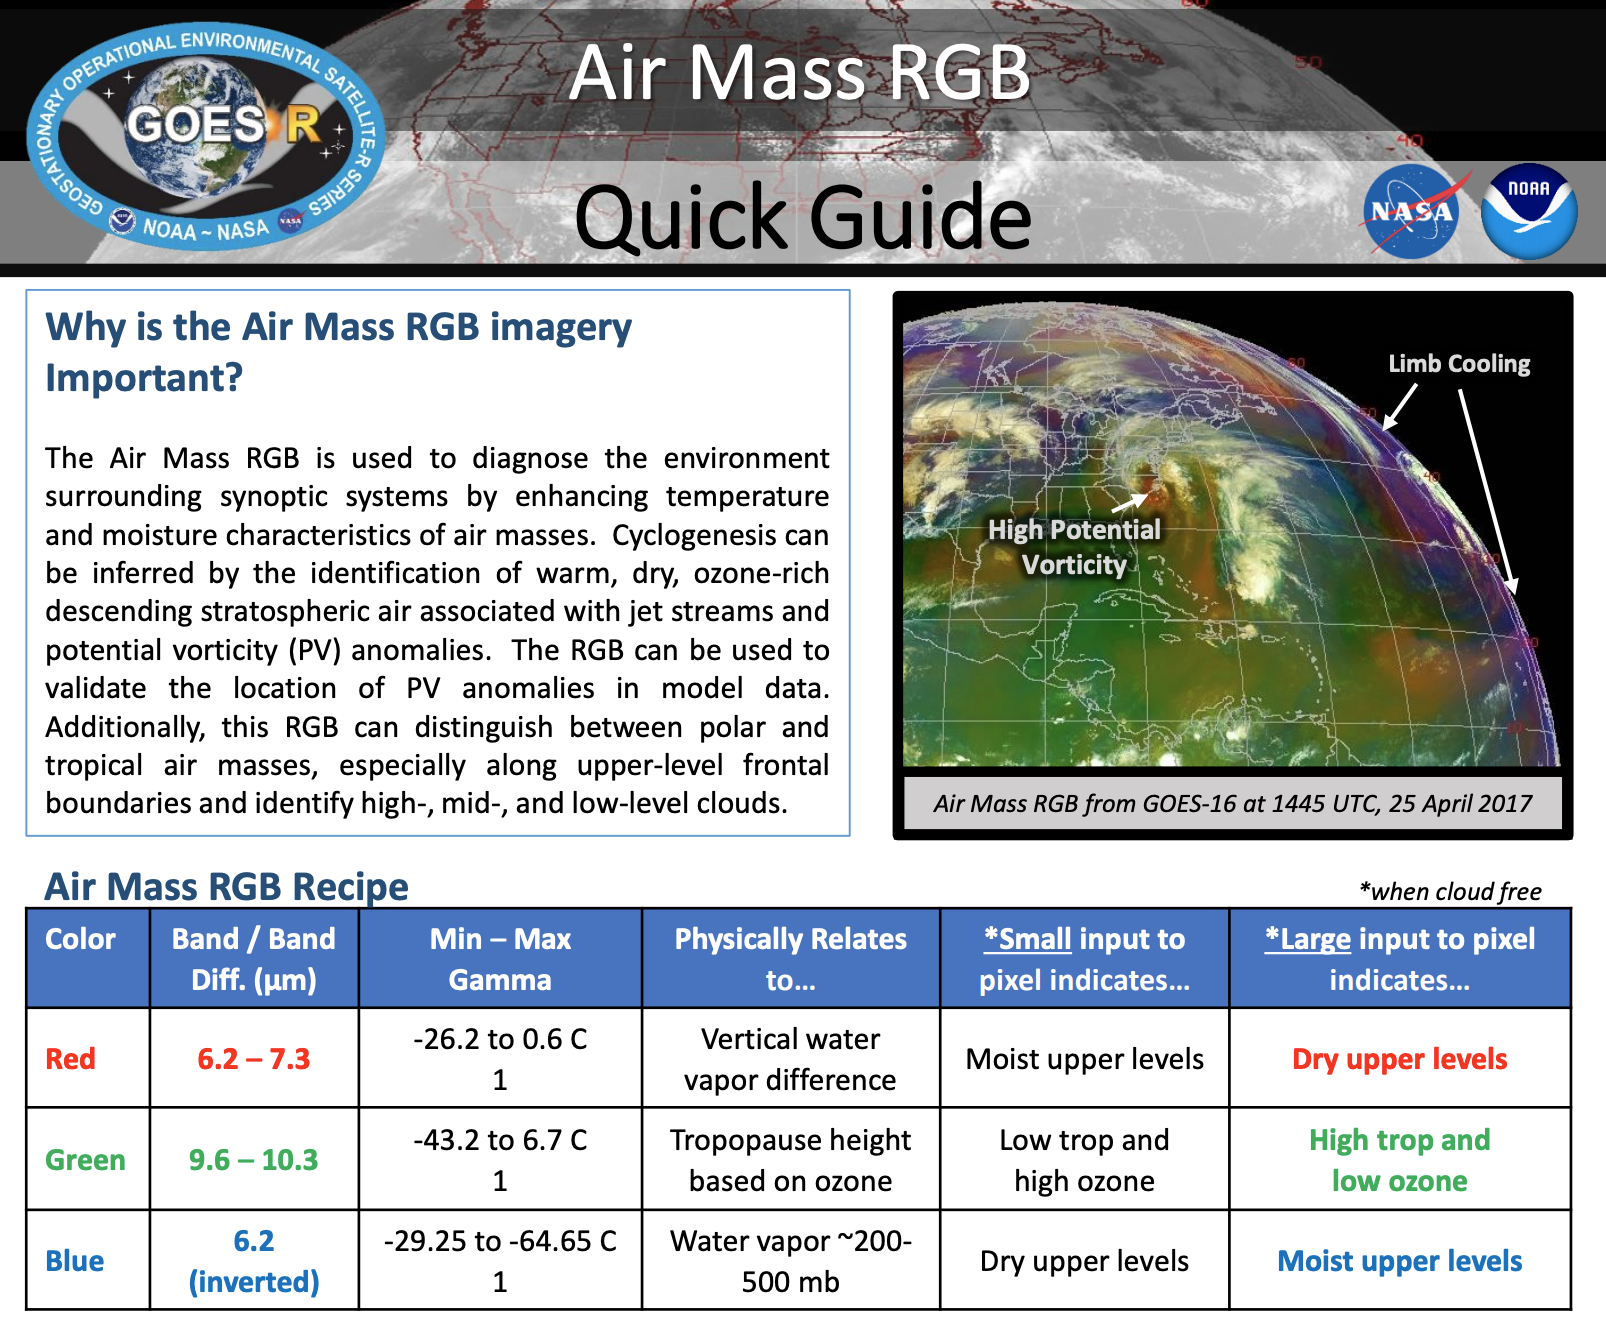


The RGB Airmass product is a combination of four different infrared bands. It is useful for identifying air masses, monitoring jet streams and jet streaks, cyclogenesis and potential vorticity maxima or anomalies.
 - The 'Red' channel is a difference of ABI bands 8 and 10
 - The 'Green' is a difference of bands 12 and 13
 - The 'Blue' is solely being represented by ABI band 8 (convert to Celsius from Kelvin).

Convert Channel to values between 0 and 1 with:
`channel = ((channel - min_val) / (max_val - min_val))**(1 / gamma)`

Where channel = the ABI band difference for Red (channel 8 - channel 10) and Green (channel 12 - channel 13).

DO NOT plug the numbers directly into the formula given above! For example:


**Code Example**

gamma = 1

orange = channel_a.values - channel_b.values, *where in this case the '.values' are brightness temperatures in deg K* 

omin = -10

omax =  10

orange = ((orange - omin) / (omax - omin))**(1 / gamma)

In [36]:
def get_satellite_data(date, region='CONUS', channel=2, satellite='east'):

    # Construct the data_url string
    data_url = (f'https://thredds.ucar.edu/thredds/catalog/satellite/goes/{satellite}/products/'
                f'CloudAndMoistureImagery/{region}/Channel{channel:02d}/'
                f'{date:%Y%m%d}/catalog.xml')

    # Get list of files available for particular day
    cat = TDSCatalog(data_url)

    # Grab dataset for desired time
    dataset = cat.datasets.filter_time_nearest(date, regex=r'_s(?P<strptime>\d{13})', strptime='%Y%j%H%M%S')

    # Open most recent file available
    ds = dataset.remote_access(use_xarray=True,service='OPENDAP').metpy.parse_cf()
    
    return ds

In [38]:
date = datetime(2024, 11, 19, 16)

ch8  = get_satellite_data(date,  channel=8).Sectorized_CMI
ch10 = get_satellite_data(date, channel=10).Sectorized_CMI
ch12 = get_satellite_data(date, channel=12).Sectorized_CMI
ch13 = get_satellite_data(date, channel=13).Sectorized_CMI

In [29]:
ch8

<xarray.DataArray 'Sectorized_CMI' (y: 1500, x: 2500)>
array([[      nan,       nan,       nan, ..., 224.19746, 224.7467 , 224.95796],
       [      nan,       nan,       nan, ..., 223.9862 , 224.36646, 224.36646],
       [      nan,       nan,       nan, ..., 223.81721, 224.28197, 223.90172],
       ...,
       [237.63292, 237.33717, 237.25267, ..., 242.4494 , 242.49165, 242.66064],
       [237.63292, 237.12592, 236.95692, ..., 242.49165, 242.49165, 242.5339 ],
       [237.63292, 237.12592, 236.87242, ..., 242.49165, 242.4494 , 242.3649 ]],
      dtype=float32)
Coordinates:
    time       datetime64[ns] 2024-11-19T16:01:16
  * y          (y) float64 4.588e+06 4.586e+06 4.584e+06 ... 1.586e+06 1.584e+06
  * x          (x) float64 -3.626e+06 -3.624e+06 ... 1.38e+06 1.382e+06
    metpy_crs  object Projection: geostationary
Attributes:
    standard_name:                                          brightness_temper...
    units:                                                  kelvin
    grid_mapping:                                           fixedgrid_projection
    valid_min:                                              0
    valid_max:                                              4095
    percent_good_pixel_qf:                                  1.0
    percent_conditionally_usable_pixel_qf:                  0.0
    percent_out_of_range_pixel_qf:                          0.0
    percent_no_value_pixel_qf:                              0.0
    percent_focal_plane_temperature_threshold_exceeded_qf:  0.0
    maximum_focal_plane_temperature:                        59.85898
    _ChunkSizes:                                            [512 512]

In [72]:
ch8.values

array([[      nan,       nan,       nan, ..., 224.19746, 224.7467 ,
        224.95796],
       [      nan,       nan,       nan, ..., 223.9862 , 224.36646,
        224.36646],
       [      nan,       nan,       nan, ..., 223.81721, 224.28197,
        223.90172],
       ...,
       [237.63292, 237.33717, 237.25267, ..., 242.4494 , 242.49165,
        242.66064],
       [237.63292, 237.12592, 236.95692, ..., 242.49165, 242.49165,
        242.5339 ],
       [237.63292, 237.12592, 236.87242, ..., 242.49165, 242.4494 ,
        242.3649 ]], dtype=float32)

In [45]:
# For plotting, pull projection from one of the satellite channels, for example
proj = ch8.metpy.cartopy_crs
proj

<Projected CRS: +proj=geos +a=6378137.0 +b=6356752.31414 +lon_0=-7 ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Geostationary Satellite (Sweep X)
Datum: Unknown based on GRS 1980 ellipsoid
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [57]:
# For plotting the satellite data you will also need the x (north/south) and y (east/west) axis sweep of the 
# ABI data. So pull then out of one of the channels!
x = ch8.x
y = ch8.y

The geostationary projection is the easiest way to plot the image on a map. Essentially, we are stretching 
the image across a map with the same projection and dimensions as the data
(see https://unidata.github.io/python-gallery/examples/mapping_GOES16_TrueColor.html).

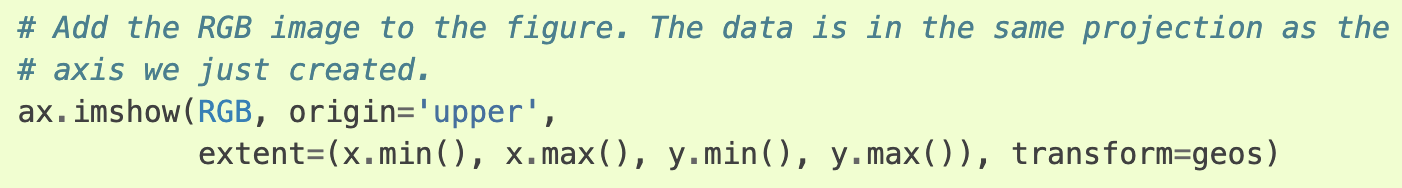

In [66]:
# Do not hardwire the time/date, pull it from the channel data!
# specify the valid time from the file
vtime = ch8.time.values.astype('datetime64[ms]').astype('O')
print(vtime)

2024-11-19 16:01:16
